In [92]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

In [93]:
dialogues_df = pd.read_csv("../data/dialouges_over_time.csv")
characters_df = pd.read_csv("../data/characters_w_map.csv")
end_sentiment_df = pd.read_csv("../data/end_sentiment.csv")
affiliations_df = pd.read_csv("../data/Affiliation_mortality.csv")


# remove ''Roose Bolton%27s son'' from character df
characters_df = characters_df[characters_df['Name'] != "Roose Bolton%27s son"]

# Dictionary for mapping specific house values
# Dictionary for mapping specific house values
house_mapping = {
    'Tully Arryn (by marriage) Baelish (by marriage)': 'Arryn',
    'Bolton ( legitimized )': 'Bolton',
    "Lannister Baratheon of King's Landing (by marriage)": 'Lannister',
    'Tully Stark (by marriage)': 'Stark',
    'Stark Lannister (by marriage) Bolton (by marriage)': 'Stark',
    'Tyrell Baratheon (by marriage) Baratheon of King\'s Landing (by marriage)': 'Tyrell',
    'Baratheon ( legitimized )': 'Baratheon',
    'Baratheon of King\'s Landing Lannister': 'Baratheon',
    "Baratheon Baratheon of King's Landing": 'Baratheon',
    'Baratheon of King\'s Landing': 'Baratheon',
    'Redwyne Tyrell (by marriage)': 'Tyrell',

}

# Fix the DataFrame by converting string representations of lists into actual lists of strings
import ast

def fix_affiliations(entry):
    """
    Converts a string representation of a list into an actual list of strings.
    """
    if isinstance(entry, str):
        try:
            # Safely evaluate the string as a Python literal
            return ast.literal_eval(entry)
        except (ValueError, SyntaxError):
            return []  # Return an empty list if the conversion fails
    return entry  # Return the entry unchanged if it's already a list

# Apply the fix to the 'Affiliation(s)' column
characters_df['Affiliation(s)'] = characters_df['Affiliation(s)'].apply(fix_affiliations)


def process_character_affiliations(character_df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    character_df = character_df.copy()

    
    # Define a helper function to process each row
    def combine_affiliations(row):
        affiliations = row['Affiliation(s)'] if isinstance(row['Affiliation(s)'], list) else []
        house = row['House(s)']
        
        # Map house value if it's in the dictionary
        if house in house_mapping:
            house = house_mapping[house]
        
        # Combine affiliations and house into a single list
        combined_list = affiliations + [house]

        # 'remove' 'unknown' from affiliations if there is atleast one more affiliation
        if 'Unknown' in combined_list:
            combined_list = [aff for aff in combined_list if aff != 'Unknown']

        # 'remove' 'nan' from affiliations if there is at least one more affiliation
        if any(math.isnan(aff) if isinstance(aff, float) else False for aff in combined_list):
            # Remove nan
            combined_list = [aff for aff in combined_list if not (isinstance(aff, float) and math.isnan(aff))]

        if row['Name'] == 'Margaery Tyrell':
            combined_list.append('Baratheon')

        return combined_list
    
    # Use .loc to set values in the dataframe
    character_df.loc[:, 'affiliations'] = character_df.apply(combine_affiliations, axis=1)
    
    return character_df

def map_sentiments_to_characters(characters_df, end_sentiment_df):
    """
    Maps sentiment values from end_sentiment_df to characters_df.

    Parameters:
        characters_df (pd.DataFrame): DataFrame containing character data, including a 'mapped' column.
        end_sentiment_df (pd.DataFrame): DataFrame containing sentiment data with 'speaker' and sentiment columns.

    Returns:
        pd.DataFrame: Updated characters_df with two new columns:
                      'final_accumulative_sentiment' and 'final_average_sentiment'.
    """
    # Initialize new columns with default value 0
    characters_df['final_accumulative_sentiment'] = 0
    characters_df['final_average_sentiment'] = 0

    # Create a dictionary mapping speakers to sentiment values for efficient lookup
    sentiment_mapping = end_sentiment_df.set_index('speaker')[['final_accumulative_sentiment', 'final_average_sentiment']].to_dict('index')

    # Map sentiments to characters
    def map_sentiments(row):
        character = row['mapped']
        if character in sentiment_mapping:
            return sentiment_mapping[character]['final_accumulative_sentiment'], sentiment_mapping[character]['final_average_sentiment']
        else:
            return 0, 0  # Default value if character is not in sentiment_mapping

    # Apply the mapping
    characters_df[['final_accumulative_sentiment', 'final_average_sentiment']] = characters_df.apply(
        lambda row: pd.Series(map_sentiments(row)),
        axis=1
    )

    return characters_df


In [94]:
characters_df = process_character_affiliations(characters_df)
characters_df = map_sentiments_to_characters(characters_df, end_sentiment_df)


In [95]:
# Count the number of lines for each character
line_counts = dialogues_df['mapped'].value_counts()

# Get the top 20 characters with the most lines
top_100_characters = line_counts.head(100).reset_index()

# Rename columns for clarity
top_100_characters.columns = ['character', 'line_count']

characters_top = characters_df.loc[characters_df['mapped'].isin(top_100_characters['character'])]
end_sentiment_top = end_sentiment_df.loc[end_sentiment_df['speaker'].isin(top_100_characters['character'])]
dialogues_top = dialogues_df.loc[dialogues_df['mapped'].isin(top_100_characters['character'])]

In [96]:
# normalise final_accumulative_sentiment and final_average_sentiment to range -1 to 1
scaler_acc = MinMaxScaler(feature_range=(-1, 1))
scaler_avg = MinMaxScaler(feature_range=(-1, 1))

# Create copies of the columns to transform
acc_values = characters_top[['final_accumulative_sentiment']].copy()
avg_values = characters_top[['final_average_sentiment']].copy()

# Fit and transform the values
characters_top.loc[:,'final_accumulative_sentiment'] = scaler_acc.fit_transform(acc_values)
characters_top.loc[:,'final_average_sentiment'] = scaler_avg.fit_transform(avg_values)

In [97]:
characters_top

,Name,Born,Died,House(s),Affiliation(s),Title(s),Culture,Father,Mother,Sibling(s),...,Personal arms,Species,Affiliation,Lover(s),Family,Dead,mapped,affiliations,final_accumulative_sentiment,final_average_sentiment
1,Anguy,"Dornish Marches , the Stormlands",NaN,NaN,[Brotherhood Without Banners],NaN,Marcher,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,anguy,[Brotherhood Without Banners],-0.323275,-0.133333
2,Lysa Arryn,"Lysa Tully Riverrun , the Riverlands","301 AC The Eyrie , the Vale of Arryn",Tully Arryn (by marriage) Baelish (by marriage),[Unknown],NaN,Rivermen,{ Hoster Tully },{ Minisa Whent },NaN,...,NaN,NaN,NaN,NaN,NaN,1,lysa arryn,[Arryn],-0.211707,0.096774
3,Robin Arryn,"289 AC (age 16) Red Keep , King's Landing",NaN,Arryn,[Royce],Lord of the Eyrie Defender of the Vale Warden ...,Valemen,{ Jon Arryn },{ Lysa Tully },NaN,...,NaN,NaN,NaN,NaN,NaN,0,robin arryn,"[Royce, Arryn]",-0.365178,-0.400000
5,Petyr Baelish,"The Fingers , the Vale of Arryn","304 AC Winterfell , the North",Baelish,"[Tully, Arryn, Baratheon, Stark]",Master of Coin (formerly) Lord of Harrenhal Lo...,Valemen,{ Lord Baelish },NaN,NaN,...,"Yellow, a black mockingbird",NaN,NaN,NaN,NaN,1,petyr baelish,"[Tully, Arryn, Baratheon, Stark, Baelish]",-0.025477,0.107143
6,Gendry Baratheon,"Gendry Flea Bottom , King's Landing",NaN,Baratheon ( legitimized ),"[Tobho Mott, Targaryen]",Lord of Storm's End Lord Paramount of the Stor...,Crownlander,{ Robert I Baratheon },NaN,NaN,...,NaN,NaN,NaN,Arya Stark,NaN,0,gendry,"[Tobho Mott, Targaryen, Baratheon]",-0.949909,-0.242424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Olenna Tyrell,"Olenna Redwyne The Arbor , the Reach","304 AC Highgarden , the Reach",Redwyne Tyrell (by marriage),[Targaryen],NaN,Reach,NaN,NaN,Viola Redwyne,...,NaN,NaN,NaN,NaN,NaN,1,olenna,"[Targaryen, Tyrell]",-0.719924,-0.151515
287,Varys,Lys,"305 AC Dragonstone , the Crownlands",NaN,"[Targaryen, Baratheon, Small Council]",Master of Whisperers,Lysene,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,varys,"[Targaryen, Baratheon, Small Council]",-0.414132,-0.051546
289,Waif,NaN,303 AC in Braavos Killed by Arya Stark with Ne...,NaN,[Faceless Men],NaN,Braavosi,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,waif,[Faceless Men],-0.761803,-0.480000
301,Ygritte,Beyond the Wall,"301 AC Castle Black , the Wall",NaN,[Mance Rayder],NaN,Free Folk,NaN,NaN,NaN,...,NaN,NaN,NaN,Jon Snow,NaN,1,ygritte,[Mance Rayder],-0.898509,-0.251462


In [98]:
# Initialize the graph
G = nx.Graph()

# Add nodes for all characters
for _, row in characters_top.iterrows():
    character = row['Name']
    G.add_node(character)  # Add the character as a node

# Add edges based on shared affiliations
for i, row_i in characters_top.iterrows():
    char_i = row_i['Name']
    affiliations_i = set(row_i['affiliations'])
    
    for j, row_j in characters_top.iterrows():
        if i >= j:  # Avoid duplicate pairs or self-loops
            continue
        char_j = row_j['Name']
        affiliations_j = set(row_j['affiliations'])
        
        # Check for shared affiliations
        if affiliations_i & affiliations_j:  # Non-empty intersection
            G.add_edge(char_i, char_j)

# Add node attributes
for _, row in characters_top.iterrows():
    character = row['Name']
    house = row.get('House(s)', 'Unknown')  # Default to 'Unknown' if column is missing
    # Map house value if it's in the dictionary
    if house in house_mapping:
        house = house_mapping[house]
    died = row.get('Died', 'Unknown')      # Default to 'Unknown' if column is missing
    culture = row.get('Culture', 'Unknown')
    final_accumulative_sentiment = row.get('final_accumulative_sentiment', 0)
    final_average_sentiment = row.get('final_average_sentiment', 0)
    # Add attributes
    G.nodes[character]['House'] = house
    G.nodes[character]['Died'] = died
    G.nodes[character]['Culture'] = culture
    G.nodes[character]['final_accumulative_sentiment'] = final_accumulative_sentiment
    G.nodes[character]['final_average_sentiment'] = final_average_sentiment

In [99]:
# print each node attribute and name of the node
for node in G.nodes():
    print(node)
    print(G.nodes[node])
    
    print('\n')

Anguy
{'House': nan, 'Died': nan, 'Culture': 'Marcher', 'final_accumulative_sentiment': -0.3232753932420804, 'final_average_sentiment': -0.1333333333333333}


Lysa Arryn
{'House': 'Arryn', 'Died': '301 AC The Eyrie , the Vale of Arryn', 'Culture': 'Rivermen', 'final_accumulative_sentiment': -0.21170735337681446, 'final_average_sentiment': 0.0967741935483871}


Robin Arryn
{'House': 'Arryn', 'Died': nan, 'Culture': 'Valemen', 'final_accumulative_sentiment': -0.3651782329065269, 'final_average_sentiment': -0.4}


Petyr Baelish
{'House': 'Baelish', 'Died': '304 AC Winterfell , the North', 'Culture': 'Valemen', 'final_accumulative_sentiment': -0.025477478579530255, 'final_average_sentiment': 0.1071428571428571}


Gendry Baratheon
{'House': 'Baratheon', 'Died': nan, 'Culture': 'Crownlander', 'final_accumulative_sentiment': -0.9499094324050826, 'final_average_sentiment': -0.2424242424242424}


Joffrey Baratheon
{'House': 'Baratheon', 'Died': "301 AC (aged 19) Red Keep, King's Landing", 'Cult

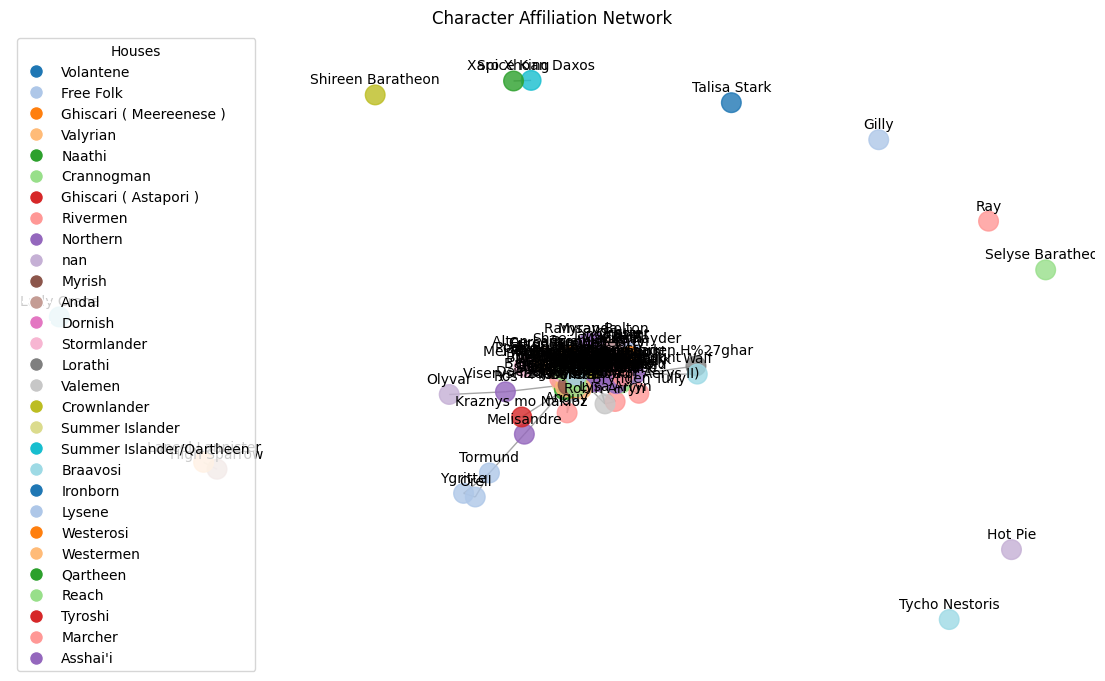

In [100]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

def draw_graph(G, node_color_attribute = 'House'):
    # Create a color map for houses
    node_attribute = set(nx.get_node_attributes(G, node_color_attribute).values())  # Get unique houses
    colors = plt.cm.tab20.colors  # Use a colormap with distinct colors
    node_attribute_color_map = {node_attribute: colors[i % len(colors)] for i, node_attribute in enumerate(node_attribute)}

    # Assign colors to nodes based on their house
    node_colors = [node_attribute_color_map[G.nodes[node].get(node_color_attribute, 'Unknown')] for node in G.nodes]

    # Draw the graph
    plt.figure(figsize=(14, 8))

    # Position nodes using a layout
    pos = nx.spring_layout(G)

    # Draw nodes with assigned colors
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors, alpha=0.8)

    # Draw edges, filtering out edges with nan affiliations
    edges = [(u, v) for (u, v) in G.edges() if not (math.isnan(G.nodes[u].get('affiliations', 0)) or math.isnan(G.nodes[v].get('affiliations', 0)))]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="gray", alpha=0.7)

    # Draw labels (names above nodes)
    offset_pos = {key: (x, y + 0.05) for key, (x, y) in pos.items()}  # Adjust position upwards
    nx.draw_networkx_labels(G, offset_pos, font_size=10, font_color="black")

    # Create a legend for the houses
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=house)
                    for house, color in node_attribute_color_map.items()]
    plt.legend(handles=legend_handles, loc='best', title="Houses")

    # Add title and turn off axis
    plt.title("Character Affiliation Network")
    plt.axis("off")
    plt.show()

draw_graph(G, node_color_attribute='Culture')


In [101]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Detect communities in the graph using Louvain's method
partition = community_louvain.best_partition(G)

# Add the community as a node attribute
nx.set_node_attributes(G, partition, 'community')

# Print communities
for node, community_id in partition.items():
    print(f"{node} belongs to community {community_id}")


Anguy belongs to community 0
Lysa Arryn belongs to community 1
Robin Arryn belongs to community 1
Petyr Baelish belongs to community 1
Gendry Baratheon belongs to community 0
Joffrey Baratheon belongs to community 0
Myrcella Baratheon belongs to community 0
Renly Baratheon belongs to community 0
Robert Baratheon belongs to community 0
Selyse Baratheon belongs to community 2
Shireen Baratheon belongs to community 3
Tommen Baratheon belongs to community 0
Ramsay Bolton belongs to community 4
Roose Bolton belongs to community 1
Bronn belongs to community 5
Jory Cassel belongs to community 1
Lady Crane belongs to community 6
Craster belongs to community 4
Xaro Xhoan Daxos belongs to community 8
Beric Dondarrion belongs to community 0
Doreah belongs to community 5
Walder Frey belongs to community 0
Gilly belongs to community 9
Grenn belongs to community 4
Grey Worm belongs to community 5
Euron Greyjoy belongs to community 5
Theon Greyjoy belongs to community 1
Yara Greyjoy belongs to commun

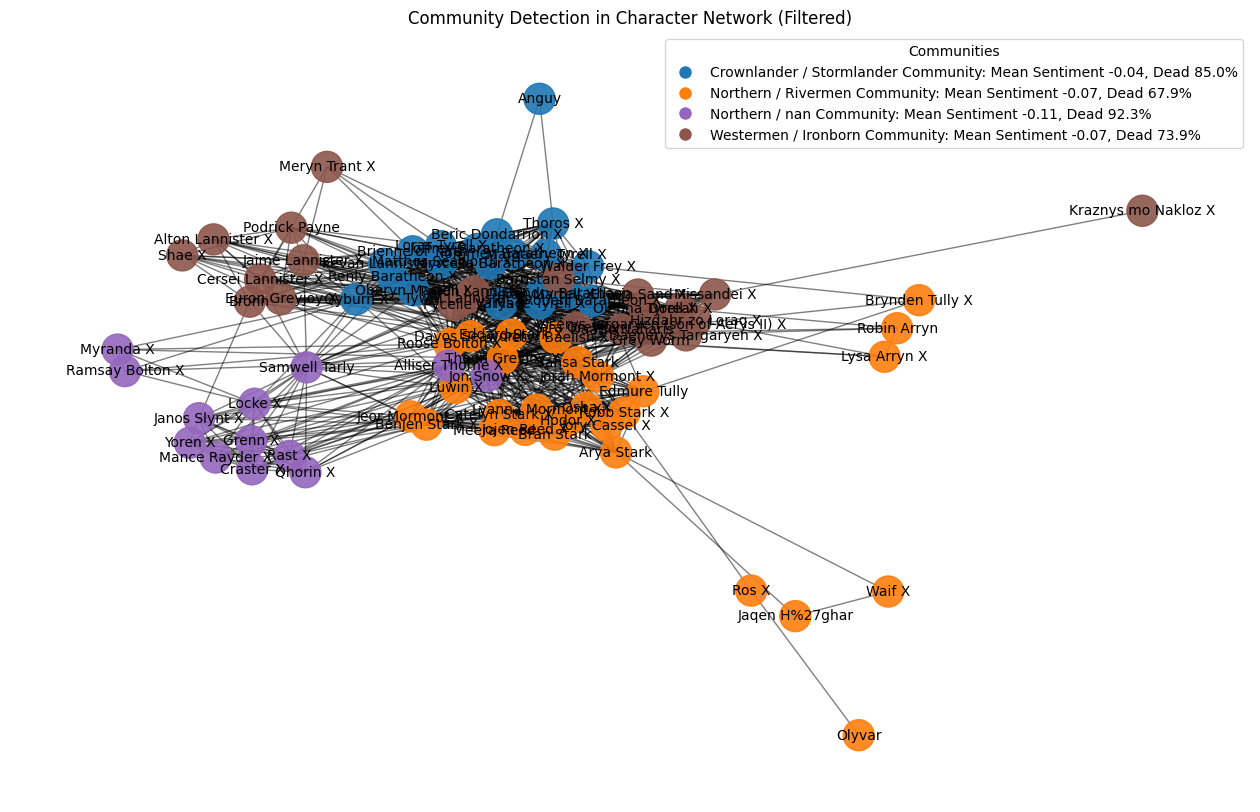

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Calculate community sizes
community_sizes = Counter(partition.values())

# Filter communities with more than 5 members
filtered_communities = {comm for comm, size in community_sizes.items() if size > 5}

# Generate unique community names based on the top two cultures
community_cultures = {}
used_names = set()

for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm]
    cultures = [G.nodes[node].get('Culture', 'Unknown') for node in community_nodes]
    most_common_cultures = [culture for culture, _ in Counter(cultures).most_common()]
    
    # Try creating unique community names
    name = f"{most_common_cultures[0]} / {most_common_cultures[1]}"  # First two cultures
    if name in used_names and len(most_common_cultures) > 2:
        # Use the first and third if the name is already taken
        name = f"{most_common_cultures[0]} / {most_common_cultures[2]}"
    elif name in used_names and len(most_common_cultures) > 3:
        # Use the first and fourth if needed
        name = f"{most_common_cultures[0]} / {most_common_cultures[3]}"
    
    # Store the name and mark it as used
    community_cultures[comm] = name
    used_names.add(name)

# Calculate mean sentiment and dead percentage for each community
community_data = {}
for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm]
    
    # Mean sentiment
    mean_sentiment = np.mean([
        G.nodes[node]['final_average_sentiment'] for node in community_nodes
    ])
    
    # Dead percentage
    total_nodes = len(community_nodes)
    dead_nodes = sum(
        1 for node in community_nodes if G.nodes[node].get('Died') and isinstance(G.nodes[node]['Died'], str)
    )
    dead_percentage = (dead_nodes / total_nodes) * 100
    
    community_data[comm] = {
        "mean_sentiment": mean_sentiment,
        "dead_percentage": dead_percentage
    }

# Create legend labels using the unique culture-based names, mean sentiment, and dead percentage
legend_labels = {
    comm: f"{community_cultures[comm]} Community: Mean Sentiment {data['mean_sentiment']:.2f}, Dead {data['dead_percentage']:.1f}%"
    for comm, data in community_data.items()
}

# Generate a colormap for the communities
cmap = plt.cm.tab10
community_color_map = {comm: cmap(comm % cmap.N) for comm in filtered_communities}

# Draw the graph
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G)

# Draw nodes only for filtered communities, with correct colors
for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm]
    nx.draw_networkx_nodes(
        G, pos, nodelist=community_nodes, node_size=500,
        node_color=[community_color_map[comm]] * len(community_nodes), alpha=0.9
    )

# Draw edges only for filtered communities
filtered_edges = [
    (u, v) for u, v in G.edges if partition[u] in filtered_communities and partition[v] in filtered_communities
]
nx.draw_networkx_edges(G, pos, edgelist=filtered_edges, alpha=0.5)

# Update labels: Add X for dead characters
updated_labels = {}
for node in G.nodes:
    name = node
    if G.nodes[node].get('Died') and isinstance(G.nodes[node]['Died'], str):
        name += " X"  # Add X for dead characters
    updated_labels[node] = name

# Draw updated labels
nx.draw_networkx_labels(G, pos, labels=updated_labels, font_size=10, font_color="black")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=community_color_map[comm], 
               markersize=10, label=label)
    for comm, label in legend_labels.items()
]
plt.legend(handles=legend_handles, loc='best', title="Communities")

plt.title("Community Detection in Character Network (Filtered)")
plt.axis("off")
plt.show()


In [103]:
# Create a list to store data for the DataFrame
data = []

# Iterate through nodes and filter only those in filtered communities
for node in G.nodes:
    community_id = partition[node]
    if community_id in filtered_communities:
        # Get node attributes
        attributes = G.nodes[node]
        
        # Add community name to attributes
        attributes['Name'] = node
        attributes['Community'] = community_cultures[community_id]
        
        # Append to data list
        data.append(attributes)

# Create DataFrame
df_comms = pd.DataFrame(data)

# add is_dead column, a character is dead if 'Died' is not nan
df_comms['is_dead'] = df_comms['Died'].notna()

# Get unique communities
communities = df_comms['Community'].unique()

In [104]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def plot_community_bars_with_support(df_comms, mean_support):

    # Get unique communities
    communities = df_comms['Community'].unique()

    for community_name in communities:
        # Create a copy of the filtered data to avoid SettingWithCopyWarning
        community_df = df_comms[df_comms['Community'] == community_name].copy()

        # Normalize the final_average_sentiment to range 0 to 1
        scaler = MinMaxScaler(feature_range=(0, 1))
        community_df.loc[:, 'final_average_sentiment'] = scaler.fit_transform(
            community_df[['final_average_sentiment']]
        )

        # Sort the data by sentiment value and create bar plot
        sorted_data = community_df.sort_values('final_average_sentiment')
        plt.figure(figsize=(8, 8))

        # Create bar plot with colors based on is_dead column
        colors = ['#8B4343' if dead else '#4B6B8C' for dead in sorted_data['is_dead']]  # Muted red and blue tones
        plt.bar(range(len(sorted_data)), sorted_data['final_average_sentiment'], color=colors)

        # Calculate average and mean support bounds
        avg_sentiment = sorted_data['final_average_sentiment'].mean()
        upper_bound = avg_sentiment + mean_support
        lower_bound = avg_sentiment - mean_support

        # if a character is not dead, and the average sentiment is above the upper bound, print the name of the character
        for index, row in sorted_data.iterrows():
            if not row['is_dead'] and row['final_average_sentiment'] > upper_bound:
                print(row['Name'])

        # Add average line (solid)
        plt.axhline(y=avg_sentiment, color='black', linestyle='-', label=f'Average ({avg_sentiment:.2f})')

        # Add mean support lines (dashed)
        plt.axhline(y=upper_bound, color='gray', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
        plt.axhline(y=lower_bound, color='gray', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')

        # Add gray shaded box between dashed lines
        plt.fill_between(
            range(len(sorted_data)), lower_bound, upper_bound,
            color='gray', alpha=0.2, label='Mean Support Range'
        )

        # Add legend and labels
        plt.legend()
        plt.title(f"{community_name} Community")
        plt.ylabel('Normalized Average Sentiment')
        plt.xticks([])  # Hide x-axis labels
        plt.show()


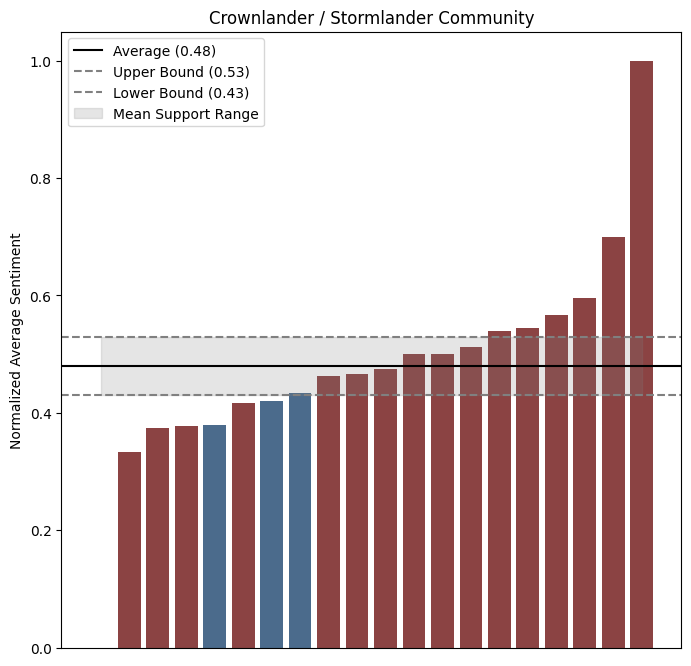

Olyvar


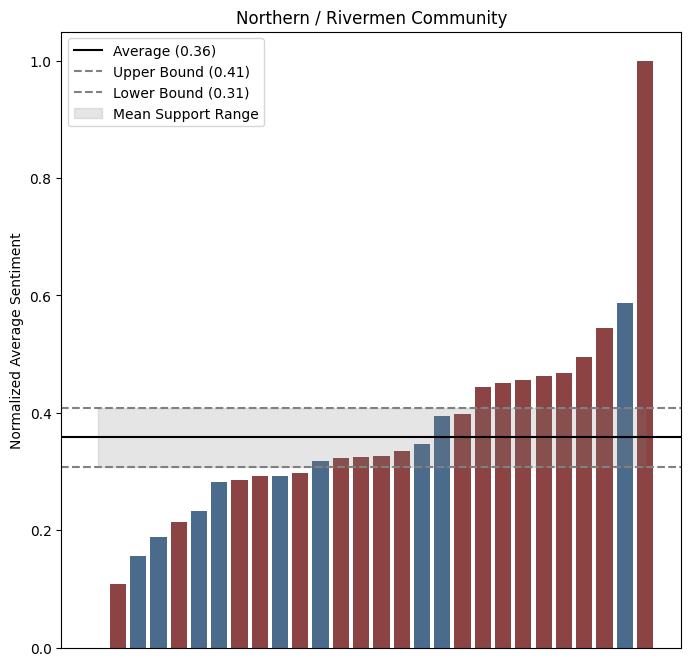

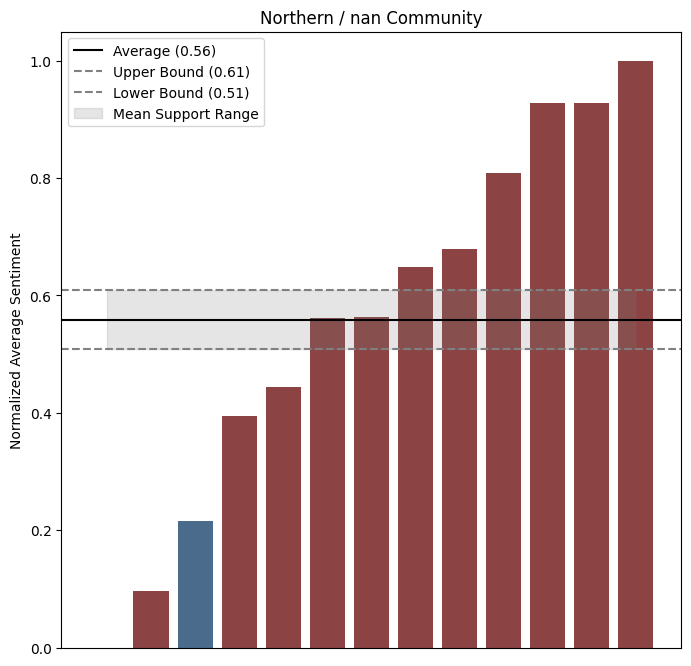

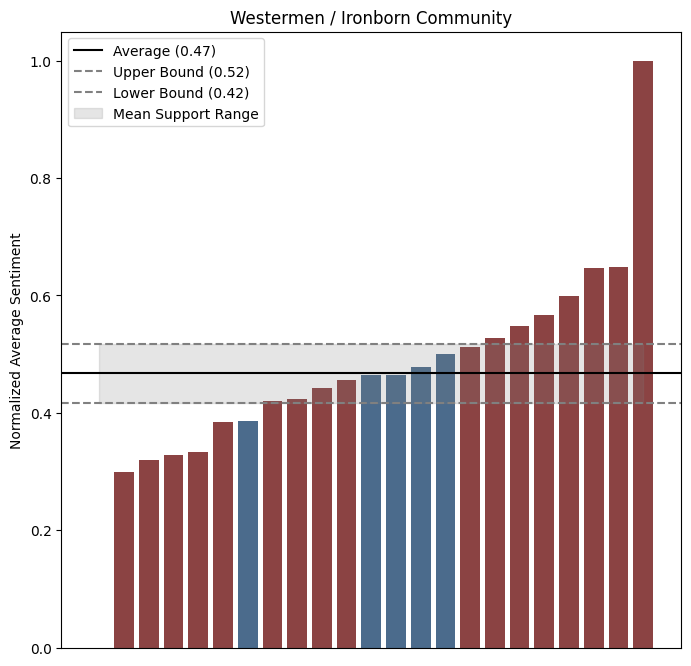

In [108]:
plot_community_bars_with_support(df_comms, mean_support=0.05)

In [106]:
communities

array(['Crownlander / Stormlander', 'Northern / Rivermen',
       'Northern / nan', 'Westermen / Ironborn'], dtype=object)

In [107]:
df_comms.loc[df_comms['Community'] == communities[2]]

,House,Died,Culture,final_accumulative_sentiment,final_average_sentiment,community,Name,Community,is_dead
10,Bolton,"303 AC Winterfell , the North",Northern,0.280052,0.096296,4,Ramsay Bolton,Northern / nan,True
14,NaN,"300 AC Craster's Keep , beyond the Wall",Free Folk,-0.317265,0.030303,4,Craster,Northern / nan,True
18,NaN,"301 AC Castle Black , the Wall",NaN,-0.514419,-0.172414,4,Grenn,Northern / nan,True
31,NaN,"301 AC Craster's Keep , beyond the Wall",Northern,-0.240747,0.096774,4,Locke,Northern / nan,True
40,NaN,"302 AC Winterfell , the North",Northern,-0.181169,0.136364,4,Myranda,Northern / nan,True
47,NaN,"299 AC The Skirling Pass , beyond the Wall",NaN,-0.434172,-0.200000,4,Qhorin,Northern / nan,True
49,NaN,301 AC near Craster's Keep Savaged by Ghost,NaN,-0.525040,-0.419355,4,Rast,Northern / nan,True
50,NaN,302 AC at Castle Black Shot with an arrow by J...,Free Folk,-0.328931,-0.107692,4,Mance Rayder,Northern / nan,True
59,Slynt,302 AC at Castle Black Beheaded by Jon Snow fo...,Andal,-0.322261,-0.058824,4,Janos Slynt,Northern / nan,True
60,Targaryen,"302 AC Castle Black , the Gift (later resurrec...",Northern,-0.498844,-0.106557,4,Jon Snow,Northern / nan,True
